# Capstone Project - Find suitable community in Chicago to open Grocery Store, Convenience Store or Market

Introduction:

As a future shop owner, you want to open a shop in the safest most profitable community that you can.

Using the reported incidents of crime and then filtering out only crimes that involved Small Retail Stores, Department Stores, Convenience Stores and Grocery Stores. Combining this data with each communities per capita income it is possible to create a cross reference of the data to make a decision.

Data Sources:
    - Reported incidents of crime (https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2/data) filtered on 2018 and exported to csv file.
    - Community Breakdown (https://en.wikipedia.org/wiki/Community_areas_in_Chicago) captured in a csv file.
    - Community Per Capita (https://data.cityofchicago.org/Health-Human-Services/Per-Capita-Income/r6ad-wvtk) exported to a csv file.

These files are placed in the "github" project folder and is imported at the start of the project.

# Declare Liabraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request, json
import requests

import sys
sys.path.append('..')
import folium
print (folium.__file__)
print (folium.__version__)

%matplotlib inline

from geopy.geocoders import Nominatim
from folium import plugins
from matplotlib.ticker import StrMethodFormatter

print('-- Libraries retrieved --')

/home/jupyterlab/conda/lib/python3.6/site-packages/folium/__init__.py
0.5.0
-- Libraries retrieved --


# Read data:

In [2]:
filename = 'https://raw.githubusercontent.com/nagol81/Capstone-Project/master/Crimes2018Incidents.csv' #'./Data/Chicago2018.csv'
df = pd.read_csv(filename, low_memory=False)

filename_communities = 'https://raw.githubusercontent.com/nagol81/Capstone-Project/master/ChicagoCommunity.csv' #'./Data/ChicagoCommunity.csv'
df_community = pd.read_csv(filename_communities) #pd.read_csv(filename_communities, low_memory=False)

filename_communities_income = 'https://raw.githubusercontent.com/nagol81/Capstone-Project/master/ChicagoPerCapitaIncome.csv' #'./Data/ChicagoPerCapitaIncome.csv'
df_community_income = pd.read_csv(filename_communities_income, low_memory=False)[:-1]
print('-- Imported Data --')

-- Imported Data --


### Clean Incident Data

- Drop Columns

In [3]:
columns = ['Case Number', 'ID', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Year', 'Updated On']
df.drop(columns, inplace=True, axis=1)
print('-- Dropped Columns from Incidents Data Frame --')

-- Dropped Columns from Incidents Data Frame --


- Filter for only Stores

In [4]:
array = ['SMALL RETAIL STORE', 'DEPARTMENT STORE', 'CONVENIENCE STORE', 'GROCERY FOOD STORE']
df = df.loc[df['Location Description'].isin(array)]
df = df.loc[~df['Latitude'].isin(['', np.nan])]
print('-- Filtered out Relevant Stores --')

-- Filtered out Relevant Stores --


- Split Date Data

In [5]:
df['Dates'] = pd.to_datetime(df['Date']).dt.date
df['Time'] = pd.to_datetime(df['Date']).dt.time
df.drop('Date', axis=1, inplace=True)
print('-- Split Date Time Column --')

-- Split Date Time Column --


- Add Incidents Column

In [6]:
df['Incidents'] = 1
df['Community Area'] = df['Community Area'].astype(int)
df['Community Area'] = df['Community Area'].astype(str)
print('-- Add Incidents column with value 1 --')

-- Add Incidents column with value 1 --


- Reset Index

In [7]:
df.reset_index(drop=True, inplace=True)
print('-- Reset Index --')

-- Reset Index --


In [8]:
df.head()

,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Latitude,Longitude,Location,Dates,Time,Incidents
0,017XX N MILWAUKEE AVE,860,THEFT,RETAIL THEFT,SMALL RETAIL STORE,False,False,1434,14,32,24,41.912407,-87.680603,"(41.912406937, -87.680602833)",2018-12-31,20:30:00,1
1,0000X S STATE ST,1150,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,DEPARTMENT STORE,False,False,112,1,42,32,41.881718,-87.627760,"(41.88171846, -87.627760426)",2018-12-31,19:51:00,1
2,073XX N ROGERS AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,CONVENIENCE STORE,False,False,2424,24,49,1,42.013796,-87.679983,"(42.013796364, -87.679982964)",2018-12-31,19:50:00,1
3,008XX S STATE ST,860,THEFT,RETAIL THEFT,SMALL RETAIL STORE,False,False,123,1,4,32,41.871489,-87.627517,"(41.871489164, -87.627516791)",2018-12-31,19:10:00,1
4,078XX S HALSTED ST,2826,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,CONVENIENCE STORE,False,True,621,6,17,71,41.751484,-87.644064,"(41.751483673, -87.644063697)",2018-12-31,19:09:00,1


### Clean Income Data

- Drop Columns

In [9]:
columns = ['PERCENT AGED UNDER 18 OR OVER 64','PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA','PERCENT OF HOUSING CROWDED','COMMUNITY AREA NAME','PERCENT HOUSEHOLDS BELOW POVERTY','PERCENT AGED 16+ UNEMPLOYED']
df_community_income.drop(columns, inplace=True, axis=1)
print('-- Dropped Columns from Income Data Frame --')

-- Dropped Columns from Income Data Frame --


- Rename Columns

In [10]:
df_community_income.rename(columns={'Community Area Number':'Community Area'}, inplace=True)
df_community_income.rename(columns={'PER CAPITA INCOME':'PerCapitaIncome'}, inplace=True)
df_community_income.rename(columns={'HARDSHIP INDEX':'HardshipIndex'}, inplace=True)
df_community_income['Community Area'] = df_community_income['Community Area'].astype(int)
df_community_income['Community Area'] = df_community_income['Community Area'].astype(str)
print('-- Cleaned up column names --')

-- Cleaned up column names --


- Reset Index

In [11]:
df_community_income.reset_index(drop=True, inplace=True)
print('-- Reset Index --')

-- Reset Index --


In [12]:
df_community_income.head()

,Community Area,PER CAPITA INCOME,HardshipIndex
0,1,23939,39.0
1,2,23040,46.0
2,3,35787,20.0
3,4,37524,17.0
4,5,57123,6.0


### Calculate Community Totals

- Create group by of Community Area and Incidents Sum

In [13]:
df_community_totals = df.groupby(['Community Area'], as_index=False)['Incidents'].agg('sum')
df_community_totals['Community Area'] = df_community_totals['Community Area'].astype(str)
df_community['Community Area'] = df_community['Community Area'].astype(str)
df_community_totals = (pd.merge(df_community, df_community_totals, on = "Community Area", how='left').fillna(0))
print('-- Created Community Totals --')

-- Created Community Totals --


- Merge Totals with Income

In [14]:
df_community_totals = pd.merge(df_community_totals, df_community_income, on='Community Area')
print('-- Merged in Community Totals with Income --')

-- Merged in Community Totals with Income --


- Reset Index

In [15]:
df_community_totals.reset_index(drop=True, inplace=True)
print('-- Reset Index --')

-- Reset Index --


In [16]:
df_community_totals.head()

,Community Area,Community Name,Incidents,PER CAPITA INCOME,HardshipIndex
0,1,Rogers Park,293.0,23939,39.0
1,2,West Ridge,147.0,23040,46.0
2,3,Uptown,270.0,35787,20.0
3,4,Lincoln Square,93.0,37524,17.0
4,5,North Center,90.0,57123,6.0


# Analyse Data

Using the community totals a bar graph is generated for the communities. The data is ordered from a community with highest crime incidents to lowest. Using this ranking we take the 20 lowest ranked communities too estimate a possible location for the new store.

### Bar Graph

- Generate Bar Graph

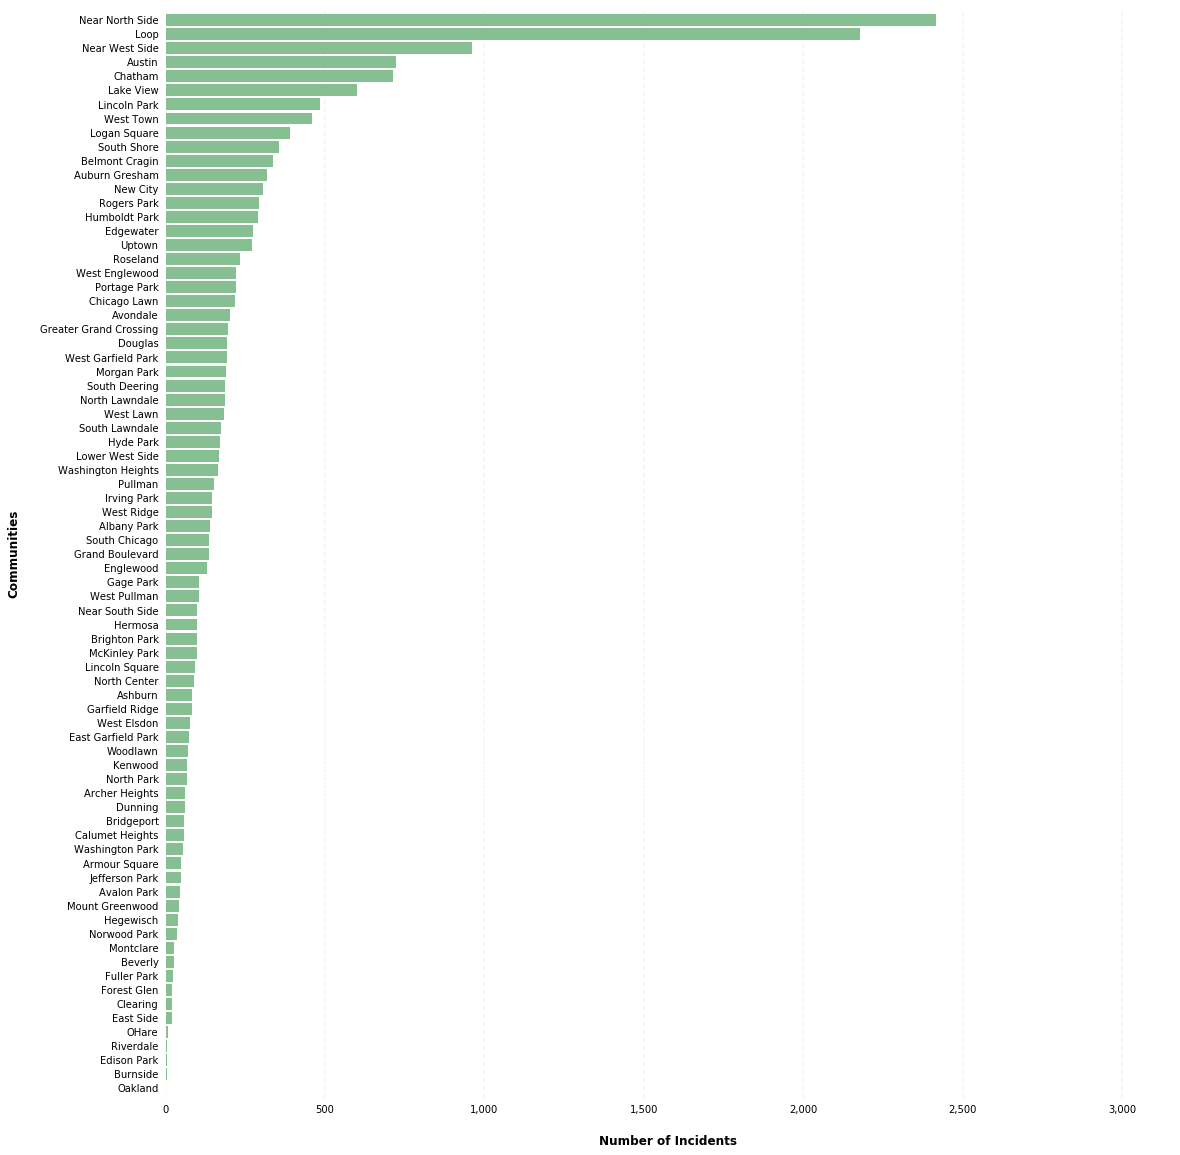

In [17]:
x = df_community_totals.groupby('Community Name')['Incidents'].mean().sort_values()
fig = plt.figure()
ax = x.plot(kind='barh', figsize=(18, 20), color='#86bf91', zorder=2, width=0.85)
# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=True, left=False, right=False, labelleft=True)

# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
  ax.axvline(x=tick, linestyle='dashed', alpha=0.7, color='#eeeeee', zorder=1)

# Set x-axis label
ax.set_xlabel("Number of Incidents", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Communities", labelpad=20, weight='bold', size=12)

# Format y-axis label
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
fig.savefig('./Data/community_numbers.png')

- Because we only interrested in the low crime regions we will only use the lowest 20 entries.

In [18]:
df_community_filtered = df_community_totals.sort_values(['Incidents'], ascending=True).head(20)
df_community_filtered.reset_index(drop=True, inplace=True)
print('-- 20 Lowest Communities Filtered --')

-- 20 Lowest Communities Filtered --


- Set Latitude, Longitude Values

In [19]:
geolocator = Nominatim(user_agent="ny_explorer")

for community_ID, community_Area in zip(df_community_filtered['Community Area'], df_community_filtered['Community Name']):
    address = '{}, Chicago'.format(community_Area)
    location = geolocator.geocode(address)    
    df_community_filtered.loc[df_community_filtered['Community Area'] == community_ID,'Latitude'] = location.latitude
    df_community_filtered.loc[df_community_filtered['Community Area'] == community_ID,'Longitude'] = location.longitude

print('-- Added Latitude, Longitude for communities --')

-- Added Latitude, Longitude for communities --


In [20]:
df_community_filtered.head(20)

,Community Area,Community Name,Incidents,PER CAPITA INCOME,HardshipIndex,Latitude,Longitude
0,36,Oakland,0.0,19252,78.0,41.823653,-87.608242
1,47,Burnside,3.0,12515,79.0,41.730035,-87.596714
2,9,Edison Park,4.0,40959,8.0,42.005733,-87.814004
3,54,Riverdale,6.0,8201,98.0,41.667835,-87.604964
4,76,OHare,9.0,25828,24.0,41.973101,-87.906768
5,64,Clearing,19.0,25113,29.0,41.780588,-87.773388
6,52,East Side,19.0,17104,64.0,41.694618,-87.533387
7,12,Forest Glen,21.0,44164,11.0,41.991752,-87.751673
8,37,Fuller Park,24.0,10432,97.0,41.818089,-87.632551
9,72,Beverly,26.0,39523,12.0,41.718153,-87.671767


### Map out Chicago Data

Having filtered the data to only 20 communities, the data is mapped out in a choropleth map to show the communities and their ratings. They are spread across the area so will yield different area data when using Foursquare to make further assessments.

- Get City Coordinates

In [21]:
# get city coordinates
address = 'OHare, Chicago'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chicago are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chicago are 41.97310105, -87.9067678854723.


- Plot a Filtered Map Showing Crime Stats

In [22]:
# create a map of Chicago
with urllib.request.urlopen("https://raw.githubusercontent.com/nagol81/Capstone-Project/master/Chicago2018CommunityAreas.geojson") as json_file:  
    boundaries = json.loads(json_file.read().decode())
    
threshold_scale = np.linspace(df_community_filtered['Incidents'].min(), df_community_filtered['Incidents'].max(), 6, dtype=int) 
threshold_scale = threshold_scale.tolist()
threshold_scale[-1] = threshold_scale[-1] + 1

map_tor = folium.Map(location=[latitude, longitude], zoom_start=10)
map_tor.choropleth(
    geo_data=boundaries,
    data=df_community_filtered,
    columns=['Community Area', 'Incidents'],
    key_on='feature.properties.area_num_1',    
    threshold_scale=threshold_scale,
    fill_color='BuGn', 
    fill_opacity=0.7, 
    line_opacity=0.5
) 

for lat, lng, label in zip(df_community_filtered['Latitude'], df_community_filtered['Longitude'], df_community_filtered['Community Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor)    

map_tor

# Foursquare Data

- Set Variables and funtion to process each community.

In [23]:
CLIENT_ID = 'VMYCK4YV4IASU4S1XH520XF3JD3W5SNHD1SLUOIDNDOMKMZA' # your Foursquare ID
CLIENT_SECRET = 'CIK4NODOYQQLWENBE5IBIAWLBW4M14M2DSRWDKEZQZCJ21OK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=100
radius=10000

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
print('AMOUNT OF VENUES:' + str(LIMIT))
print('RADIUS(m):' + str(radius))

Your credentails:
CLIENT_ID: VMYCK4YV4IASU4S1XH520XF3JD3W5SNHD1SLUOIDNDOMKMZA
CLIENT_SECRET:CIK4NODOYQQLWENBE5IBIAWLBW4M14M2DSRWDKEZQZCJ21OK
AMOUNT OF VENUES:100
RADIUS(m):10000


- Declare Usable Functions

In [24]:
def getNearbyCategoryVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?categoryId=4d4b7105d754a06378d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['id'],
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Community Name', 
                  'Community Latitude', 
                  'Community Longitude', 
                  'Id',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):           
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Community Name', 
                  'Community Latitude', 
                  'Community Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Retrieve Venues

In [26]:
chicago_venues = getNearbyCategoryVenues(names=df_community_filtered['Community Name'], latitudes=df_community_filtered['Latitude'], longitudes=df_community_filtered['Longitude'])
print('-- Retrieved Shops From the Area --')

-- Retrieved Shops From the Area --


- Remove any duplicate entries

In [27]:
chicago_venues.drop_duplicates(subset='Id', keep='last',inplace=True) 
print('-- Remove Duplicate Entries --')

-- Remove Duplicate Entries --


In [28]:
chicago_venues.head()

,Community Name,Community Latitude,Community Longitude,Id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Oakland,41.823653,-87.608242,4fef19a3e4b0d96619dc32bb,effortless style studio 3960 cottage grove,41.821654,-87.606963,Boutique
1,Oakland,41.823653,-87.608242,4db0a473f7b1bd003acd4794,Issues Barber & Beauty Salon,41.822216,-87.607170,Salon / Barbershop
2,Oakland,41.823653,-87.608242,59ba1a0d2079551e2b7c172e,Bp,41.823597,-87.612130,Gas Station
3,Oakland,41.823653,-87.608242,5872c8a6c5f8a7566a3dc807,BP,41.823690,-87.615074,Gas Station
4,Oakland,41.823653,-87.608242,50ee3627e4b02b52c828eb20,Quik Mart,41.823840,-87.615073,Gas Station


- Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [29]:
# one hot encoding
chicago_onehot = pd.get_dummies(chicago_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chicago_onehot['Community Name'] = chicago_venues['Community Name'] 

# move neighborhood column to the first column
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]
print('-- Finished Grouping by Category --')

-- Finished Grouping by Category --


- Group data by Community

In [30]:
chicago_grouped = chicago_onehot.groupby('Community Name').mean().reset_index()
print('-- Group by Community --')

-- Group by Community --


In [34]:
chicago_grouped.head(21)

,Community Name,ATM,Accessories Store,Adult Boutique,Antique Shop,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,Bank,...,Storage Facility,Supermarket,Tanning Salon,Tattoo Parlor,Thrift / Vintage Store,Video Game Store,Video Store,Warehouse Store,Wine Shop,Women's Store
0,Armour Square,0.000000,0.00,0.000000,0.000,0.000000,0.032258,0.000000,0.129032,0.000000,...,0.032258,0.000000,0.032258,0.000000,0.000000,0.000000,0.000000,0.032258,0.00000,0.000000
1,Avalon Park,0.028571,0.00,0.000000,0.000,0.028571,0.000000,0.000000,0.085714,0.000000,...,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2,Beverly,0.000000,0.00,0.025641,0.000,0.000000,0.000000,0.000000,0.025641,0.025641,...,0.025641,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.051282
3,Bridgeport,0.000000,0.00,0.000000,0.000,0.000000,0.000000,0.000000,0.162791,0.069767,...,0.000000,0.000000,0.000000,0.000000,0.023256,0.023256,0.000000,0.000000,0.00000,0.000000
4,Burnside,0.000000,0.00,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
5,Calumet Heights,0.000000,0.00,0.000000,0.000,0.000000,0.000000,0.076923,0.076923,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
6,Clearing,0.045455,0.00,0.000000,0.000,0.000000,0.000000,0.000000,0.045455,0.045455,...,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.090909,0.000000,0.00000,0.000000
7,East Side,0.000000,0.00,0.000000,0.000,0.000000,0.000000,0.000000,0.166667,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.00000,0.000000
8,Edison Park,0.000000,0.00,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.031250,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.03125,0.000000
9,Forest Glen,0.000000,0.00,0.000000,0.000,0.000000,0.000000,0.000000,0.105263,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


### Display Ten most popular shops

After filtering the data for all venues in the communities they are grouped together showing top 10 shops for each community. We order the grid by the hardship index for each community. Using this it is possible to see which area has low indication of convenience stores or grocery stores. We can make assumptions about a possible good community to set the business up in.

- function to sort the venues in descending order.

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

- Generate grid of Top 10 venues in Community

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Community Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Store'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Store'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Community Name'] = chicago_grouped['Community Name']

for ind in np.arange(chicago_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

print("-- Processed the Grid --")

-- Processed the Grid --


- Create new Data Frame merging the incidents with the top 10 most common.

In [37]:
chicago_merged = df_community_filtered

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_temp = chicago_merged.join(neighborhoods_venues_sorted.set_index('Community Name'), on='Community Name')

chicago_merged = df_temp.sort_values(['HardshipIndex'], ascending=[1])
print('-- Merged data --')

-- Merged data --


- Display the Grid

In [38]:
chicago_merged

,Community Area,Community Name,Incidents,PER CAPITA INCOME,HardshipIndex,Latitude,Longitude,1st Most Common Store,2nd Most Common Store,3rd Most Common Store,4th Most Common Store,5th Most Common Store,6th Most Common Store,7th Most Common Store,8th Most Common Store,9th Most Common Store,10th Most Common Store
2,9,Edison Park,4.0,40959,8.0,42.005733,-87.814004,Salon / Barbershop,Spa,Grocery Store,Photography Lab,Real Estate Office,Print Shop,Clothing Store,Cosmetics Shop,Nail Salon,Design Studio
7,12,Forest Glen,21.0,44164,11.0,41.991752,-87.751673,Financial or Legal Service,Miscellaneous Shop,Credit Union,Automotive Shop,Grocery Store,Currency Exchange,Salon / Barbershop,Nail Salon,Mobile Phone Shop,Boutique
9,72,Beverly,26.0,39523,12.0,41.718153,-87.671767,Salon / Barbershop,Boutique,Cosmetics Shop,Financial or Legal Service,Spa,Clothing Store,Miscellaneous Shop,Farmers Market,Women's Store,Storage Facility
13,74,Mount Greenwood,41.0,34381,16.0,41.698089,-87.708662,Cosmetics Shop,Salon / Barbershop,Women's Store,Electronics Store,Credit Union,Currency Exchange,Daycare,Deli / Bodega,Design Studio,Discount Store
11,10,Norwood Park,37.0,32875,21.0,41.985590,-87.800577,ATM,Automotive Shop,Furniture / Home Store,Flower Shop,Pet Store,Cheese Shop,Real Estate Office,Hardware Store,Farmers Market,Daycare
4,76,OHare,9.0,25828,24.0,41.973101,-87.906768,Newsstand,Electronics Store,Miscellaneous Shop,Chocolate Shop,Bookstore,Gift Shop,Credit Union,Convenience Store,Food & Drink Shop,Accessories Store
15,11,Jefferson Park,47.0,27751,25.0,41.969738,-87.763118,Salon / Barbershop,Bank,Automotive Shop,Financial or Legal Service,Pharmacy,Video Store,Laundry Service,Paper / Office Supplies Store,Other Repair Shop,Convenience Store
5,64,Clearing,19.0,25113,29.0,41.780588,-87.773388,Salon / Barbershop,Video Store,Nail Salon,ATM,Credit Union,Pharmacy,Office,Real Estate Office,Record Shop,Business Service
18,48,Calumet Heights,57.0,28887,38.0,41.730035,-87.579213,Salon / Barbershop,Furniture / Home Store,Hardware Store,Pharmacy,Gas Station,Laundry Service,Auto Workshop,Automotive Shop,Women's Store,Dry Cleaner
14,45,Avalon Park,45.0,24454,41.0,41.745035,-87.588658,Salon / Barbershop,Automotive Shop,Nail Salon,Boutique,Car Wash,Miscellaneous Shop,Health Food Store,Health & Beauty Service,Pet Service,Mobile Phone Shop


### Assumptions

Taking the above data the following neighbourhoods are reviewed individually to see what other venues are available that might make the community a viable option for the store.

- Reviewing the information manually to see what else is in the area

In [40]:
manual_venues = getNearbyCategoryVenues(names=df_community_filtered['Community Name'], latitudes=df_community_filtered['Latitude'], longitudes=df_community_filtered['Longitude'])
manual_venues[manual_venues['Community Name']=='Edison Park']


,Community Name,Community Latitude,Community Longitude,Id,Venue,Venue Latitude,Venue Longitude,Venue Category
22,Edison Park,42.005733,-87.814004,50f1d84de4b0ba6d636e075c,Sara Marie Prints Studio,42.004505,-87.815559,Design Studio
23,Edison Park,42.005733,-87.814004,4ed15a310e01f1a880fb3bce,Wine Compliments,42.008172,-87.812784,Wine Shop
24,Edison Park,42.005733,-87.814004,4d107d0be236548119ef77ea,World Wide Liqour,42.003128,-87.816616,Liquor Store
25,Edison Park,42.005733,-87.814004,4ed159a5722e01c583837352,Baubles and Bags,42.003282,-87.816994,Jewelry Store
26,Edison Park,42.005733,-87.814004,4c4464eb56a7ef3b8141ce21,Black & White Photography,42.003273,-87.817099,Photography Lab
27,Edison Park,42.005733,-87.814004,4f7df4b9e4b06277b594a72c,Mike's Barber Shop,42.002316,-87.815605,Salon / Barbershop
28,Edison Park,42.005733,-87.814004,564500b9498edf3cd0e14e4d,Farmers Insurance,42.001367,-87.817311,Insurance Office
29,Edison Park,42.005733,-87.814004,4b8808e7f964a520a5da31e3,o'connors irish market,42.003196,-87.816839,Grocery Store
30,Edison Park,42.005733,-87.814004,5408e90e498e47c10676b778,Keller Williams Realty Partners,42.007746,-87.817608,Real Estate Office
31,Edison Park,42.005733,-87.814004,57907066498eeaf3c0a8d37b,L'e NuVo Salon and Spa,42.002223,-87.818023,Salon / Barbershop
